# HA3 "Recommender System" take 07

## Setup

In [141]:
import numpy as np
import pandas as pd

from random import randrange

## Load Data

In [142]:
file_path = "../../data/assignment_03/"

baskets_pq = "baskets.parquet"
coupons_pq = "coupons.parquet"
prediction_index_pq = "prediction_index.parquet"

b_df = pd.read_parquet(file_path + baskets_pq)
c_df = pd.read_parquet(file_path + coupons_pq)
pi_df = pd.read_parquet(file_path + prediction_index_pq)

print(f"baskets_df: {b_df.shape}")
print(f"coupons_df: {c_df.shape}")
print(f"prediction_index_df: {pi_df.shape}")

baskets_df: (68841598, 4)
coupons_df: (45000000, 4)
prediction_index_df: (500000, 3)


## Data Preprocessing

### A. Reduce number of shoppers

In [143]:
shoppers = [randrange(0, 2000) for i in range(3)]
shoppers

[1739, 24, 139]

### B. Original Prices

In [144]:
orig_price = b_df.groupby(["product"])["price"].agg(["max"]).reset_index()
print(f"orig_price.shape: {orig_price.shape}")
orig_price.head(2)

orig_price.shape: (250, 2)


,product,max
0,0,688
1,1,560


### C. Generate master dataframe with selected shoppers

In [145]:
def gen_complete_week_prod_df_for_shoppers(list_shoppers, orig_df):
    products = np.array([p for p in range(250)])
    orig_price_list = orig_df["max"].values
    
    weeks = [i for i in range(90)]
    
    product_price_pair = np.stack((products, orig_price_list), axis=0).T
    
    prod_in_weeks = []
    for w in weeks:
        for p in product_price_pair:
            prod_in_weeks.append([w, *p])
    
    df_template = pd.DataFrame(data=prod_in_weeks, columns=["week", "product", "orig_price"])
    
    df_master = None;
    
    for idx, shoppers in enumerate(list_shoppers):

        df_local = df_template.copy()
        df_local["shopper"] = shoppers
        
        if idx == 0:
            df_master = df_local
        else:
            # stack it
            df_master = pd.concat([df_master, df_local], axis=0)
    return df_master

In [146]:
df = gen_complete_week_prod_df_for_shoppers(shoppers, orig_price)
print(f"df.shape: {df.shape}")
df.head(3)

df.shape: (67500, 4)


,week,product,orig_price,shopper
0,0,0,688,1739
1,0,1,560,1739
2,0,2,773,1739


### D. Target Column added

In [147]:
b_df["target"] = 1
df = pd.merge(df, b_df, how="left", on=["week", "shopper", "product"])
df["target"] = df["target"].fillna(0)
print(f"df.shape: {df.shape}")
df.head(3)

df.shape: (67500, 6)


,week,product,orig_price,shopper,price,target
0,0,0,688,1739,NaN,0.0
1,0,1,560,1739,NaN,0.0
2,0,2,773,1739,NaN,0.0


### E. Discount Given Column added

In [148]:
c_df["coupon_given"] = 1
df = df.merge(right=c_df, how="left", on=["week", "shopper", "product"])
df["discount"] = df["discount"].fillna(0)
df["coupon_given"] = df["coupon_given"].fillna(0)
print(f"df.shape: {df.shape}")
df.head(3)

df.shape: (67500, 8)


,week,product,orig_price,shopper,price,target,discount,coupon_given
0,0,0,688,1739,NaN,0.0,0.0,0.0
1,0,1,560,1739,NaN,0.0,0.0,0.0
2,0,2,773,1739,NaN,0.0,0.0,0.0


### F. Price with discount

In [149]:
df["price_w_discount"] = df["orig_price"] - df["discount"]
df.head(3)

,week,product,orig_price,shopper,price,target,discount,coupon_given,price_w_discount
0,0,0,688,1739,NaN,0.0,0.0,0.0,688.0
1,0,1,560,1739,NaN,0.0,0.0,0.0,560.0
2,0,2,773,1739,NaN,0.0,0.0,0.0,773.0


In [150]:
# price column is no longer necessary so removing it
df = df.drop(columns=["price"])
df.head(3)

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount
0,0,0,688,1739,0.0,0.0,0.0,688.0
1,0,1,560,1739,0.0,0.0,0.0,560.0
2,0,2,773,1739,0.0,0.0,0.0,773.0


## Split Data Before Feature Engineering

In [151]:
# Train: 0 - 84
# Test: 85 - 89

# Separate train and test
train = df[df["week"] < 85]
test = df[df["week"] >= 85]

b_train = b_df[b_df["week"] < 85]
b_test = b_df[b_df["week"] >= 85]

c_train = c_df[c_df["week"] < 85]
c_test = c_df[c_df["week"] >= 85]

print(f"Master: {df.shape}, Train: {train.shape}, Test: {test.shape}")

Master: (67500, 8), Train: (63750, 8), Test: (3750, 8)


## Feature Engineering

### A. Shopper's Perspective - Average Basket Size per Shopper per Week

In [152]:
num_prod_per_week_per_shopper = b_train.groupby(["shopper", "week"], as_index=False)["product"].count()
num_prod_per_week_per_shopper = num_prod_per_week_per_shopper.rename({"product": "avg_basket_size"}, axis=1)
avg_baskets = num_prod_per_week_per_shopper.groupby(["shopper"], as_index=False)["avg_basket_size"].mean()

In [153]:
# Merge to shoppers on train and test

train = train.merge(avg_baskets, how="left", on="shopper")
test = test.merge(avg_baskets, how="left", on="shopper")

In [154]:
train.sample(3)

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount,avg_basket_size
19878,79,128,630,1739,0.0,0.0,0.0,630.0,8.552941
1403,5,153,501,1739,0.0,0.0,0.0,501.0,8.552941
50631,32,131,519,139,0.0,0.0,0.0,519.0,8.070588


In [155]:
test.sample(3)

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount,avg_basket_size
1927,87,177,694,24,0.0,0.0,0.0,694.0,9.952941
580,87,80,614,1739,0.0,0.0,0.0,614.0,8.552941
2426,89,176,681,24,0.0,0.0,0.0,681.0,9.952941


### B Shopper's Perspective - Average price per Shopper per Week 
- How much on average did a shopper spend a week?

In [156]:
avg_price_per_shopper_per_week = b_train.groupby(["shopper"], as_index=False)["price"].mean()

In [157]:
# Include it to the shoppers

train = train.merge(avg_price_per_shopper_per_week, how="left", on="shopper")
test = test.merge(avg_price_per_shopper_per_week, how="left", on="shopper")

In [158]:
train = train.rename({"price": "avg_price"}, axis=1)
test = test.rename({"price": "avg_price"}, axis=1)

In [159]:
train.sample(3)

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount,avg_basket_size,avg_price
3940,15,190,721,1739,0.0,0.0,0.0,721.0,8.552941,607.862448
6958,27,208,536,1739,0.0,0.0,0.0,536.0,8.552941,607.862448
58319,63,69,752,139,0.0,0.0,0.0,752.0,8.070588,582.169096


In [160]:
test.sample(3)

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount,avg_basket_size,avg_price
542,87,42,527,1739,0.0,0.0,0.0,527.0,8.552941,607.862448
170,85,170,615,1739,0.0,0.0,0.0,615.0,8.552941,607.862448
1666,86,166,707,24,0.0,0.0,0.0,707.0,9.952941,579.472813


### C. Shopper's Perspective on each product - Reorder (boolean)
- Did a shopper reorder a product?

In [162]:
reordered = (b_train.groupby(['shopper']).product.value_counts()>1).astype(int)
reordered = reordered.to_frame('reordered').reset_index()
reordered.head(3)

,shopper,product,reordered
0,0,91,1
1,0,71,1
2,0,225,1


In [163]:
train = train.merge(reordered, how="left", on=["shopper","product"])
test = test.merge(reordered, how="left", on=["shopper","product"])

train["reordered"] = train["reordered"].fillna(0)
test["reordered"] = test["reordered"].fillna(0)

In [164]:
train.sample(3)

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount,avg_basket_size,avg_price,reordered
9446,37,196,721,1739,0.0,10.0,1.0,711.0,8.552941,607.862448,0.0
43396,3,146,596,139,0.0,0.0,0.0,596.0,8.070588,582.169096,0.0
32174,43,174,753,24,0.0,0.0,0.0,753.0,9.952941,579.472813,0.0


In [165]:
test.sample(3)

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount,avg_basket_size,avg_price,reordered
2456,89,206,429,24,0.0,0.0,0.0,429.0,9.952941,579.472813,1.0
1818,87,68,748,24,0.0,0.0,0.0,748.0,9.952941,579.472813,0.0
3355,88,105,504,139,0.0,0.0,0.0,504.0,8.070588,582.169096,1.0


### D. Product's Perspective - Purchased Frequency per Week

## Model Declaration and Setup for Predictive Analysis

### A. X_train, X_test, y_train, y_test split

In [166]:
train.head(2)

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount,avg_basket_size,avg_price,reordered
0,0,0,688,1739,0.0,0.0,0.0,688.0,8.552941,607.862448,1.0
1,0,1,560,1739,0.0,0.0,0.0,560.0,8.552941,607.862448,0.0


In [167]:
test.head(2)

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount,avg_basket_size,avg_price,reordered
0,85,0,688,1739,0.0,0.0,0.0,688.0,8.552941,607.862448,1.0
1,85,1,560,1739,0.0,0.0,0.0,560.0,8.552941,607.862448,0.0


In [172]:
# Features to drop for X
features_to_drop = ["target", "week"]

X_train = train.drop(columns=features_to_drop)
y_train = train[["target"]]

X_test = test.drop(columns=features_to_drop)
y_test = test[["target"]]

In [173]:
X_train.shape

(63750, 9)

### B. Model Declaration

In [175]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import mean_absolute_error
# from sklearn import tree

#### B - 1. RandomForestClassifier

In [176]:
rfc = RandomForestClassifier(random_state=888, max_depth=10, verbose=1)
rfc.fit(X_train, y_train)

<ipython-input-176-3079e819ef45>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=888,
                       verbose=1, warm_start=False)

In [177]:
rfc_pred_test = rfc.predict(X_test)
rfc_pred_test

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


array([0., 0., 0., ..., 0., 0., 0.])

In [178]:
mean_absolute_error(rfc_pred_test, y_test)

0.03626666666666667

In [179]:
rfc_pred_test_prob = rfc.predict_proba(X_test)
rfc_pred_test_prob[:,0]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


array([0.85516067, 0.9993169 , 0.99985254, ..., 0.99940382, 0.99850245,
       0.99849469])

#### B - 2. DecisionTreeClassifier

In [180]:
dtc = DecisionTreeClassifier(criterion="gini", max_depth=10)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [181]:
dtc_pred_test = dtc.predict(X_test)
dtc_pred_test

array([0., 0., 0., ..., 0., 0., 0.])

In [182]:
mean_absolute_error(dtc_pred_test, y_test)

0.0368

In [183]:
dtc_pred_test_prob = dtc.predict_proba(X_test)
dtc_pred_test_prob[:,0]

array([0.88372093, 0.99866644, 1.        , ..., 0.99866726, 0.99931694,
       1.        ])

#### B - 3. LGBM

In [184]:
import lightgbm as lgb

clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

/Users/jungwoojamesjeong/opt/anaconda3/envs/hu-mlim/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jungwoojamesjeong/opt/anaconda3/envs/hu-mlim/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [185]:
clf_pred_test = clf.predict(X_test)
clf_pred_test

array([0., 0., 0., ..., 0., 0., 0.])

In [186]:
mean_absolute_error(clf_pred_test, y_test)

0.036533333333333334

In [187]:
clf_pred_test_prob = clf.predict_proba(X_test)
clf_pred_test_prob[:,0]

array([0.87993896, 0.99975719, 0.99976044, ..., 0.99996706, 0.99995013,
       0.99995468])

## Model Assessment - ROC AUC

In [190]:
from sklearn import metrics  # Important lib where we find various performance measures

# cmat = metrics.confusion_matrix(y_test, pred_y)
# print(cmat)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


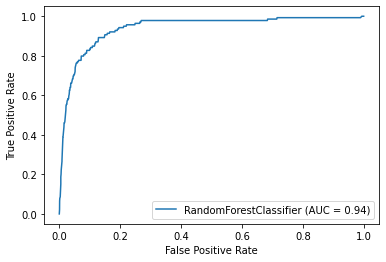

In [191]:
metrics.plot_roc_curve(rfc, X_test, y_test)

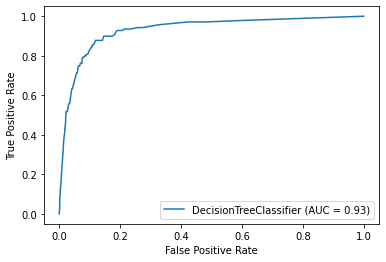

In [192]:
metrics.plot_roc_curve(dtc, X_test, y_test)

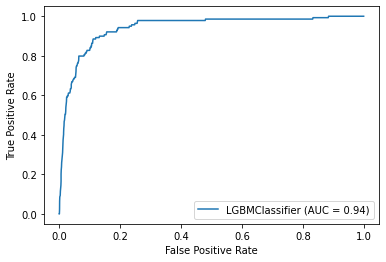

In [193]:
metrics.plot_roc_curve(clf, X_test, y_test)